# Lab 02. Feature selection and GridSearch


In this lab we will tackle two types of tasks: feature selection and hyperparameter tuning.

Lectures and seminars you might find useful:
- Lectures 1 - 4
- Seminars 2 and 3


#### Evaluation

Each task has its value, **15 points** in total. If you use some open-source code please make sure to include the url.

#### How to submit
- Name your file according to this convention: `2021_lab02_GroupNumber_Surname_Name.ipynb`, for example 
    - `2021_lab02_404_Sheipak_Sviat.ipynb`
    - `2021_lab02_NoGroup_Sheipak_Sviat.ipynb`
- Attach your .ipynb to an email with topic `2021_lab02_GroupNumber_Surname_Name.ipynb`
- Send it to `cosmic.research.ml@yandex.ru`
- Deadline is ` 2021-10-20 23:00:00 +03:00`

#### The Data:
- All the datasets you need are here: https://disk.yandex.ru/d/gaagp2G9BsvcFA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Feature Selection [4 points]

In this part of the assignemt you will be offered a task to analyze a dataset and figure out which features are the most important. The first means to solve this problem is to use linear model and examine the weights, another option is to train a logic classifier and see which featires it uses to build the splits. And finally you may use PCA and analyze how new PCA-features are configured.

Firstly, load the data from `feature_selection_sample.txt` and save it into variable `db`.

In [2]:
input_filename = 'data/feature_selection_sample.txt'
db = pd.read_csv(input_filename, sep='\t', header=None)

In [3]:
db.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.550508,19.483747,-0.002987,4.421460,5.541652,0.468138,-0.017365,0.005496,0.931543,-0.033190,15
1,9.683788,14.336396,-0.027154,5.100489,8.179487,0.573692,-0.024525,0.002686,0.880111,-0.040193,17
2,4.682631,8.112067,-0.012813,4.680838,1.514920,0.974407,-0.009002,0.007909,0.050082,-0.053341,12
3,7.768197,2.074808,-0.014950,7.977821,13.602144,0.599069,-0.018800,0.012021,0.632768,-0.035886,16
4,4.078857,8.307135,-0.004062,9.351602,6.661857,0.193607,-0.019705,0.007799,0.868582,-0.028378,20


Feature columns are `[0-9]` and the target is `[10]`. Split the table into object and target arrays:

In [4]:
X = db.iloc[:, :10]
Y = db.iloc[:, 10]

Now split the data into train and test

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
RANDOM_SEED = 42

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=RANDOM_SEED)

**Task 1.1 [1 point] Linear models**

Import `LinearRegression` and define a problem with default parameters.

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
model_lr = LinearRegression()

Train the model and check the quality both on train set and test set. Since we are solving a regression problem, we will use `mean_squared_error` as a quality metric.

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
model_lr.fit(X_train, Y_train)
train_pred = model_lr.predict(X_train)
test_pred = model_lr.predict(X_test)
train_score = mean_squared_error(Y_train, train_pred)
test_score = mean_squared_error(Y_test, test_pred)

print("Linear Regression scores: train: {:.3f}, test: {:3.3f}".format(train_score, test_score))
original_test_score = test_score 

Linear Regression scores: train: 5.814, test: 6.916


Extract feature-vector from the trained model (see [this page](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)) and bar-plot them.

No handles with labels found to put in legend.


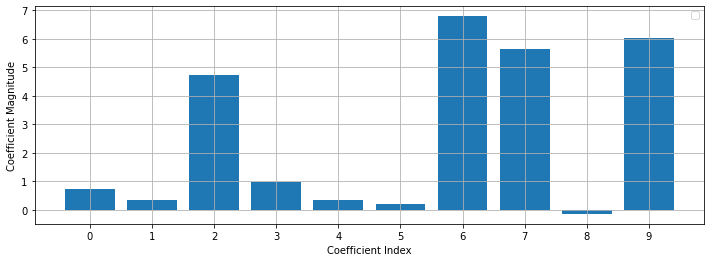

In [12]:
model_coefs = model_lr.coef_

ncoef = model_coefs.shape[0]
default_x = np.arange(ncoef)

plt.figure(figsize=(12,4))
plt.bar(np.arange(ncoef), model_coefs)
plt.xticks(default_x)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc='upper right')
plt.grid()
plt.show()

According to this plot, what are the most important features?

**Your answer here**: the most important features are 6, 7, 9 and 2.

Save 4 most important feature indexes to a list:

In [13]:
important_feature_idx = np.argsort(np.abs(model_coefs))[-4:]

In [14]:
important_feature_idx

array([2, 7, 9, 6])

Use these feature indexes to construct new train and test sets with smaller amount of features:

In [15]:
X_train_smaller = X_train[important_feature_idx]
X_test_smaller = X_test[important_feature_idx]

Define a new `LinearRegression` model, train and test it on new sets: 

In [16]:
smaller_model = LinearRegression()
smaller_model.fit(X_train_smaller, Y_train)
train_pred = smaller_model.predict(X_train_smaller)
test_pred = smaller_model.predict(X_test_smaller)
train_score = mean_squared_error(Y_train, train_pred)
test_score = mean_squared_error(Y_test, test_pred)
print("{} train score: {:.3f}, test score: {:3.3f}".format('Smaller LR', train_score, test_score))

Smaller LR train score: 22.244, test score: 26.171


Compare scores of `model_lr` (variable `original_score`) and `smaller_model` (variable `smaller_test_score`). We reduced number of feature but why scores changes so drastically?

In [17]:
print("{} test score: {:.3f}, {} test score: {:.3f}".format('Original LR', original_test_score, 'Smaller LR', test_score))

Original LR test score: 6.916, Smaller LR test score: 26.171


The main idea is that we chose "important" features incorrectly because we didn't take into account that our features can take values in the different ranges:

In [18]:
print("feature 6 range: from {} to {}".format(min(X_train.iloc[:, 6]), max(X_train.iloc[:, 6])))

feature 6 range: from -0.0299753758194856 to -4.31163772009314e-05


In [19]:
print("feature 1 range: from {} to {}".format(min(X_train.iloc[:, 1]), max(X_train.iloc[:, 1])))

feature 1 range: from 0.0017017731443047 to 19.99918435234576


We can see that the range of values for the feature 1 is bigger than for the feature 6. Therefore, we have an influence to coefficients of linear regression, there is a tendency of underestatement of coefficients for features with wider range of values.

**Task 1.2 [1 point] Linear models on scaled data**

It is time to fix this failure and scale the data - we should have done it earlier, since we decided to use linear models. Import the scaler and apply it to all of the data (`X`)

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
st_scaler = StandardScaler()
X_scaled = pd.DataFrame(st_scaler.fit_transform(X))

Now we repeat all the steps:
- split the data
- train a model on all features
- plot coefficients
- choose 4 most-important features
- train a model on a feature-subset
- compare the scores
- profit!

In [22]:
X_sc_train, X_sc_test, Y_sc_train, Y_sc_test = train_test_split(X_scaled, Y, test_size=0.1, random_state=RANDOM_SEED)

In [23]:
model_lr_sc = LinearRegression()
model_lr_sc.fit(X_sc_train, Y_sc_train)
train_pred = model_lr_sc.predict(X_sc_train)
test_pred = model_lr_sc.predict(X_sc_test)
train_score = mean_squared_error(train_pred, Y_sc_train)
test_score = mean_squared_error(test_pred, Y_sc_test)
print("Linear Regression on Scaled Data scores: train: {:.3f}, test: {:3.3f}".format(train_score, test_score))

Linear Regression on Scaled Data scores: train: 5.814, test: 6.916


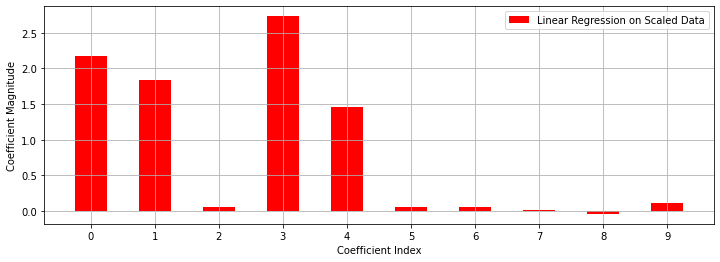

In [24]:
model_coefs = model_lr_sc.coef_

ncoef = model_coefs.shape[0]
default_x = np.arange(ncoef)

plt.figure(figsize=(12,4))
plt.bar(default_x, model_coefs, label='Linear Regression on Scaled Data', width=0.5, color = 'red')
plt.xticks(default_x)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc='upper right')
plt.grid()
plt.show()

What are the most important features now? Let's do the sanity check and train on this subset:

**Answer:** The most important features are 0, 1, 3, 4

In [25]:
important_feature_idx = np.argsort(np.abs(model_coefs))[-4:]

In [26]:
X_sc_train_smaller = X_sc_train[important_feature_idx]
X_sc_test_smaller = X_sc_test[important_feature_idx]

In [27]:
model_lr_sc_smaller = LinearRegression()
model_lr_sc_smaller.fit(X_sc_train_smaller, Y_sc_train)
train_pred = model_lr_sc_smaller.predict(X_sc_train_smaller)
test_pred = model_lr_sc_smaller.predict(X_sc_test_smaller)
train_score = mean_squared_error(Y_sc_train, train_pred)
test_score = mean_squared_error(Y_sc_test, test_pred)
print("Linear Regression on Scaled Data scores: train: {:.3f}, test: {:3.3f}".format(train_score, test_score))

Linear Regression on Scaled Data scores: train: 5.841, test: 6.856


Has **MSE** changed? To what extent?

**Your answer here**: Yes, MSE changed. With four the most important features it decreased from 6.916 to 6.856 on the test set (insignificantly).

**Task 2 [2 points] Decision Tree**

As you probably now, there are models that are not influence by the fact that data is not normalized: for example, Decision Tree or Random Forest.

Since you already have all the sets prepared: `X_train` and `X_sc_train`, train a RF model and prove that scaling does not affect feature importances.

Then compare durations of training loops for a set with 10 features and 4 features.

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
rf = RandomForestRegressor()
rf_scaled = RandomForestRegressor()

In [30]:
rf.fit(X_train, Y_train)
rf_scaled.fit(X_sc_train, Y_train)
rf_test_score = rf.score(X_train, Y_train)
rf_scaled_test_score = rf_scaled.score(X_sc_train, Y_train)
print("RF test score {:.3f}".format(rf_test_score))
print("RF scaled test score {:.3f}".format(rf_scaled_test_score))

RF test score 0.981
RF scaled test score 0.981


Look up an attribute for feature importances [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor)

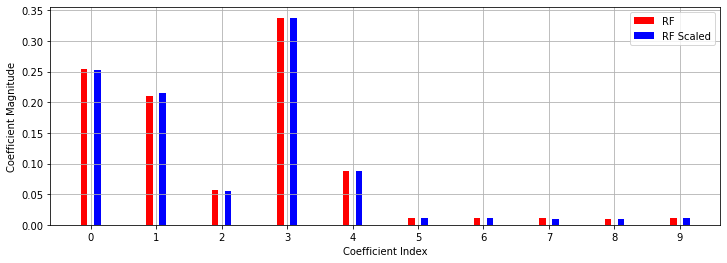

In [31]:
rf_model_coefs = rf.feature_importances_
rf_scaled_model_coefs = rf_scaled.feature_importances_
ncoef = rf_model_coefs.shape[0]
default_x = np.arange(ncoef)

plt.figure(figsize=(12,4))
plt.bar(default_x - 0.1, rf_model_coefs, label="RF", width=0.1, color = 'red')
plt.bar(default_x + 0.1, rf_scaled_model_coefs, label="RF Scaled", width=0.1, color = 'blue')
plt.xticks(default_x)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc='upper right')
plt.grid()
plt.show()

**Your Comment on the plot:**

We can see that scaling doesn't affect on the feature importance in the case of the Random Forest. It's quite logical, because Random Forest сhoose a threshold to split each feature according to maximize some impurity metric therefore range of values doesn't affect.

Now examine how reduction of number of features impacts durations of training loops. You may use `time` module.

Here is an example:

In [32]:
from time import time

n = 1000
a = np.diag(np.ones(n)) + np.random.rand(n, n)

start = time()
det = np.linalg.det(a)
end = time()
print("{} x {} matrix determinant took {:.3f} seconds".format(n, n, end - start))

1000 x 1000 matrix determinant took 0.273 seconds


/Users/anastasialavruhina/.virtualenvs/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [33]:
rf1 = RandomForestRegressor()
rf2 = RandomForestRegressor()

In [34]:
start1 = time()
rf1.fit(X_sc_train, Y_sc_train)
end1 = time()
print("Random forest on all features {:.3f} seconds".format(end1 - start1))

Random forest on all features 0.348 seconds


In [35]:
X_sc_train_small = X_sc_train[np.argsort(rf_model_coefs)[-4:]]
start2 = time()
rf1.fit(X_sc_train_small, Y_sc_train)
end2 = time()
print("Random forest on 4 most important features {:.3f} seconds".format(end2 - start2))

Random forest on 4 most important features 0.275 seconds


**Your Comment on time consuption**: We can see that training on 4 most important features (~0.197 seconds) is faster than training on all features (~0.397). I think the reason of such result is that the less feature we have, the less features we consider while construstring the tree (or smaller random subset of features to construct each decision tree in the forest), therefore it's constructed faster -> less nodes in the tree.

## Part 2. GridSearch: hyperparameter tuning  [11 points]

In this part we will try to solve a multiclass classification task on Richter's dataset ([source](https://www.kaggle.com/mullerismail/richters-predictor-modeling-earthquake-damage)). The aim is to predict damage rate (label from 1 to 3).

We will experiment with following models:
- kNN
- LinearRegression
- DecisionTree
- RandomForest

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Read the data, transform the table into arrays `X` and `y`, target column is called *damage_grade*. Note that objects are described with both numerical and categorical features. In the first part of this assignment we will use numerical features only (apply `_get_numeric_data()` to `pandas` dataframe).

Split the data into `train`, `test` and `val` with ratio 4-to-2-to-1. Since we are going to use metric classifiers, don't forget to preprocess the data.

In [30]:
RANDOM_SEED = 42

In [31]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [32]:
data = pd.read_csv("data/richters_sample.csv")
objects = data.drop(columns='damage_grade')
labels = data['damage_grade']

In [33]:
X = objects._get_numeric_data()
y = labels

assert X.shape == (35000, 31) and  y.shape == (35000,)

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [35]:
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, test_size=3/7, 
                                                    shuffle=True, stratify=y,
                                                    random_state=RANDOM_SEED)

X_test, X_val, y_test, y_val = train_test_split(X_not_train, y_not_train, test_size=1/3, 
                                                    shuffle=True, stratify=y_not_train,
                                                    random_state=RANDOM_SEED)

assert X_train.shape[0] == 20000 and X_test.shape[0] == 10000 and X_val.shape[0] == 5000

Import the models:

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Import classification quality metrics:

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

**Task 2.1 [2 points]. Default-parameter models**

Let's take 4 classifiers (1 of a kind) with **default** parameters and check how well they can perform.

In [40]:
clf1 = KNeighborsClassifier()
clf2 = LogisticRegression()
clf3 = DecisionTreeClassifier()
clf4 = RandomForestClassifier()

default_classifiers = [clf1, clf2, clf3, clf4]

Fit each classifier on `X_train, y_train`, predict on `X_test`

In [46]:
clf_predictions = []
for clf in default_classifiers:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    clf_predictions.append(pred)

Apply 5 metrics to each prediction:

In [47]:
accuracies = [accuracy_score(y_test, pred) for pred in clf_predictions]
micro_precisions = [precision_score(y_test, pred, average="micro", zero_division=1) for pred in clf_predictions] 
micro_recalls = [recall_score(y_test, pred, average='micro') for pred in clf_predictions]
macro_precisions = [precision_score(y_test, pred, average='macro') for pred in clf_predictions]
macro_recalls = [recall_score(y_test, pred, average='macro') for pred in clf_predictions]

scores = [accuracies, micro_precisions, micro_recalls, macro_precisions, macro_recalls]
names = ["Accuracies", "Micro-Precisions", "Micro-Recalls",  "Macro-Precisions", "Macro-Recalls"]

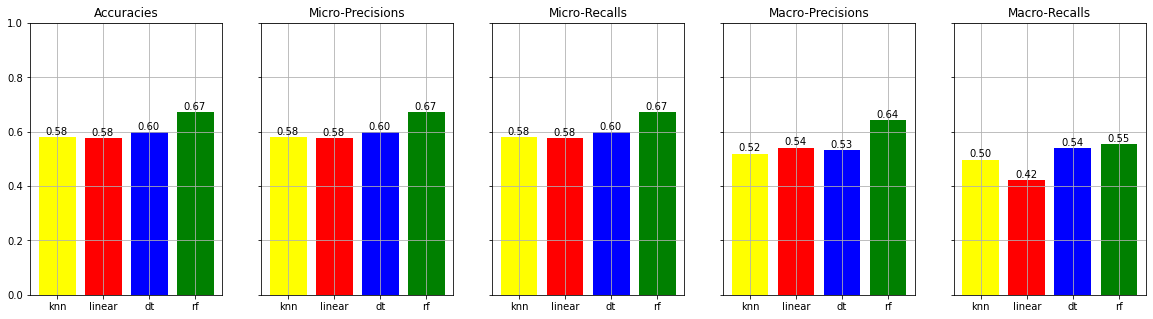

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
plt.setp(axs, ylim=(0, 1))

xlabels = ["knn", "linear", "dt", "rf"]
colors = ["yellow", "red", "blue", "green"]
xticks = 1 + np.arange(len(xlabels))

for ax, score, name in zip(axs, scores, names):
    ax.bar(xticks, score, color=colors)
    for i, v in enumerate(score):
        ax.text(xticks[i] - 0.25, v + 0.01, "{:.2f}".format(v))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_title(name)
    ax.grid()

plt.show()

Choose the model with the biggest gap between micro-precision and macro-precision and plot its confusion matrix.
For confusion matrix do `from sklearn.metrics import confusion_matrix` (don't forget to put valid labels on plots).

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [50]:
weakest_model_index = 2 #decision tree 

dt_preds = clf_predictions[weakest_model_index]
conf_matrix = confusion_matrix(y_test, clf_predictions[weakest_model_index])

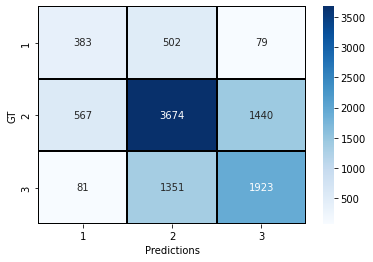

In [51]:
sns.heatmap(conf_matrix, 
            cmap="Blues",
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()),
            linewidths=0.01, linecolor="black", 
            annot = True, fmt='2g')

plt.ylabel("GT")
plt.xlabel("Predictions")
plt.show()

In [52]:
print('1 class objects num: {}, 2 class objects num: {}, 3 class objects num: {}'.format(np.count_nonzero(y_test == 1),
     np.count_nonzero(y_test == 2), np.count_nonzero(y_test == 3)))

1 class objects num: 964, 2 class objects num: 5681, 3 class objects num: 3355


Going by confusion matrix, which class is the hardest to predict? How does it affect macro/micro-precision?

**Your answer:** Classes are unbalanced in our data set: we have 964 objects of class 1, 5681 objects of the second one, and 3355 objects of class 3. From the confusion matrix we can see that the first class is quite hard to predict, from 964 elements we have only 371 true classifications and 593 misclassifications. Macro precision estimates the performance of the model in total: it computes the precision independently for each class and take the average, therefore it treats each class equally. For this reason misclassifications of class 1 affect on it strongly. Instead, micro-precision aggregate all true positive results and compute the average, therefore it treats the classes with the bigger number of elements better and misclassifications of class 1 affect it less.

**Task 2.2 [3 points]. 1-D Grid Search**

No wonder that default models have scores far from perfect. Let's tweak those hyperparameters with GridSearch: we will iteratively look through all combinations of parameters in the grid and choose the best. At each iteraction use cross validation score with number of folds `k=5`.

Firstly, build the grid for kNN. It will be a 1-D grid with the only parameter `n_neighbors`. Look through all values from 1 to 50.

*Hint*: `np.arange`, `np.linspace` and `np.logspace` are very useful for grid constructions.

**Attention** this part of assignment may need a lot of computational powers (as you probably remember, training of knn is quite expensive). 

To save some resources while doing grid search for knn you may use the trick from Part1: do feature-selection with DTree/RandomForest and select top-5 or top-10 features.

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Let's make top-10 feature-selection using RandomForest:

In [48]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
forest_coefs = rf.feature_importances_
important_feature_idx = np.argsort(np.abs(forest_coefs))[-10:]

In [49]:
X_train_selected = X_train[:, important_feature_idx]
X_test_selected = X_test[:, important_feature_idx]
X_val_selected = X_val[:, important_feature_idx]

In [50]:
knn_clf = KNeighborsClassifier()
knn_grid = {
    "n_neighbors": np.arange(1, 51)
}

In [52]:
knn_grid_searcher = GridSearchCV(knn_clf, knn_grid, cv=5, return_train_score=True)
knn_grid_searcher.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             return_train_score=True)

Plot mean cross-validation score for each hyperparameter:
- X-axis is hyperparameter values
- Y-axis is mean CV-score

To show variance of obtained estimatets add *mean + 3 stds* and *mean - 3 stds* to the plot. You may use `plt.fill_between` to make it more descriptive (it will look like a coridor around the mean).

To get values we need to plot search in `knn_grid_searcher` parameters and attributes.

In [53]:
means_train = knn_grid_searcher.cv_results_['mean_train_score']
stds_train = knn_grid_searcher.cv_results_['std_train_score']
means_test = knn_grid_searcher.cv_results_['mean_test_score']
stds_test = knn_grid_searcher.cv_results_['std_test_score']

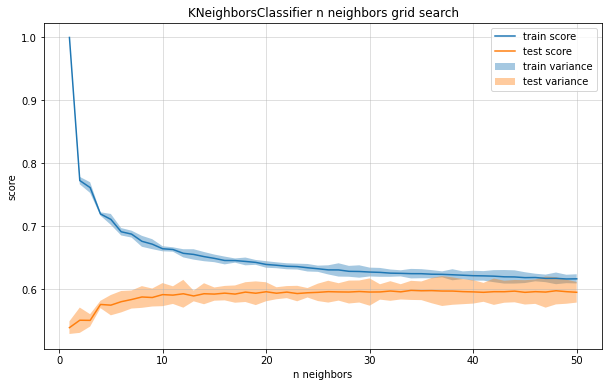

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 51), means_train, label='train score')
plt.plot(np.arange(1, 51), means_test, label='test score')
plt.fill_between(np.arange(1, 51), means_train + 3*stds_train, means_train - 3*stds_train, alpha=0.4, label='train variance')
plt.fill_between(np.arange(1, 51), means_test + 3*stds_test, means_test - 3*stds_test, alpha=0.4, label='test variance')

plt.xlabel('n neighbors')
plt.ylabel('score')
plt.legend()
plt.title('KNeighborsClassifier n neighbors grid search')
plt.grid(alpha=0.5)
plt.show()

Print the best estimator and its score:

In [60]:
print("Best estimator: {}".format(knn_grid_searcher.best_params_))
print("Best score: {:.5f}".format(knn_grid_searcher.best_score_))

Best estimator: {'n_neighbors': 45}
Best score: 0.59840


Now do the same for 3 other models:
- Decision Tree: grid search the `max_depth` parameter
- LogisticRegression: `penalty`
- RandomForest: `n_estimators`

Some of the hyperparameters are not numeric, but categorical (like `penalty`) and you should choose some other way to plot cv-scores instead of `plt.plot`

In [62]:
dt_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_grid = {
    "max_depth": np.arange(1, 21)
}

In [63]:
dt_grid_searcher = GridSearchCV(dt_clf, dt_grid, cv=5, return_train_score=True)
dt_grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             return_train_score=True)

In [66]:
means_train = dt_grid_searcher.cv_results_['mean_train_score']
stds_train = dt_grid_searcher.cv_results_['std_train_score']
means_test = dt_grid_searcher.cv_results_['mean_test_score']
stds_test = dt_grid_searcher.cv_results_['std_test_score']

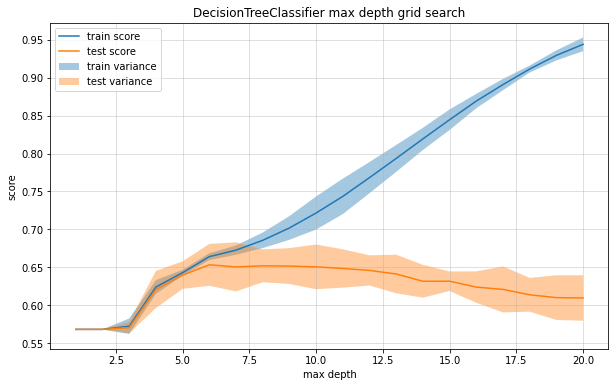

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 21), means_train, label='train score')
plt.plot(np.arange(1, 21), means_test, label='test score')
plt.fill_between(np.arange(1, 21), means_train + 3*stds_train, means_train - 3*stds_train, alpha=0.4, label='train variance')
plt.fill_between(np.arange(1, 21), means_test + 3*stds_test, means_test - 3*stds_test, alpha=0.4, label='test variance')

plt.xlabel('max depth')
plt.ylabel('score')
plt.legend()
plt.title('DecisionTreeClassifier max depth grid search')
plt.grid(alpha=0.5)
plt.show()

In [65]:
print("Best estimator: {}".format(dt_grid_searcher.best_params_))
print("Best score: {:.5f}".format(dt_grid_searcher.best_score_))

Best estimator: {'max_depth': 6}
Best score: 0.65330


In [69]:
lr_clf = LogisticRegression(solver='saga', random_state=RANDOM_SEED)
lr_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear']},
    {'penalty': ['l2', 'none'], 'solver': ['lbfgs']},
    {'penalty': ['elasticnet'], 'solver': ['saga']}
    ]

In [70]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

simplefilter("ignore", category=(ConvergenceWarning, UserWarning, FitFailedWarning))

lr_grid_searcher = GridSearchCV(lr_clf, lr_grid, cv=5, return_train_score=True)
lr_grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid=[{'penalty': ['l1'], 'solver': ['liblinear']},
                         {'penalty': ['l2', 'none'], 'solver': ['lbfgs']},
                         {'penalty': ['elasticnet'], 'solver': ['saga']}],
             return_train_score=True)

In [74]:
means_test = lr_grid_searcher.cv_results_['mean_test_score']
stds_test = lr_grid_searcher.cv_results_['std_test_score']

***COMMENT:*** elasticnet regularization doesn't converge

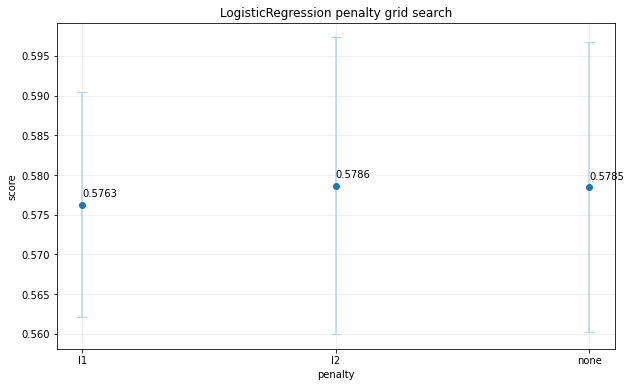

In [76]:
plt.figure(figsize=(10, 6))

plt.errorbar(np.arange(1, 4), means_test[:-1], yerr=3*stds_test[:-1], ecolor='lightblue', capsize=5, linestyle='None', fmt='o')
plt.text(1, means_test[0]+0.001, "{:.4f}".format(means_test[0]))
plt.text(2, means_test[1]+0.001, "{:.4f}".format(means_test[1]))
plt.text(3, means_test[2]+0.001, "{:.4f}".format(means_test[2]))

plt.xticks(np.arange(1, 4), ['l1', 'l2', 'none'])
plt.title('LogisticRegression penalty grid search')
plt.ylabel('score')
plt.xlabel('penalty')
plt.grid(alpha=0.25)
plt.show()

In [70]:
print("Best estimator: {}".format(lr_grid_searcher.best_params_))
print("Best score: {:.5f}".format(lr_grid_searcher.best_score_))

Best estimator: {'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.57865


In [77]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_grid = {
    "n_estimators": np.arange(1, 51)
}

In [78]:
rf_grid_searcher = GridSearchCV(rf_clf, rf_grid, cv=5, return_train_score=True)
rf_grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             return_train_score=True)

In [82]:
means_train = rf_grid_searcher.cv_results_['mean_train_score']
stds_train = rf_grid_searcher.cv_results_['std_train_score']
means_test = rf_grid_searcher.cv_results_['mean_test_score']
stds_test = rf_grid_searcher.cv_results_['std_test_score']

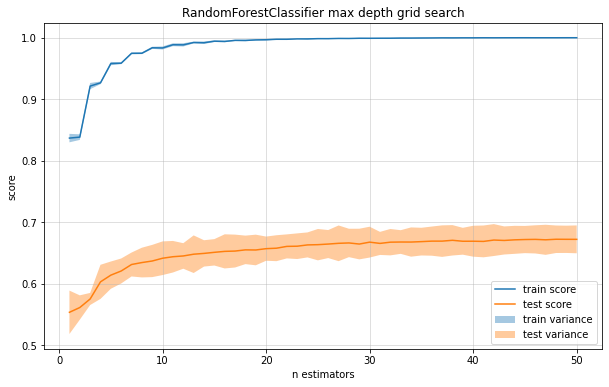

In [83]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 51), means_train, label='train score')
plt.plot(np.arange(1, 51), means_test, label='test score')
plt.fill_between(np.arange(1, 51), means_train + 3*stds_train, means_train - 3*stds_train, alpha=0.4, label='train variance')
plt.fill_between(np.arange(1, 51), means_test + 3*stds_test, means_test - 3*stds_test, alpha=0.4, label='test variance')

plt.xlabel('n estimators')
plt.ylabel('score')
plt.legend()
plt.title('RandomForestClassifier max depth grid search')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
print("Best estimator: {}".format(rf_grid_searcher.best_params_))
print("Best score: {:.5f}".format(rf_grid_searcher.best_score_))

Best estimator: {'n_estimators': 48}
Best score: 0.67220


**Task 2.3 [3 points] 2-D Grid Search**

Now it's time to improve the models with a 2-D grid search. For each classifier we will look for an optimal **pair** of hyperparameters. However, going through the whole grid may be computationally expensive, so here are some ways to speed it up:

1. Make sparse grids with fewer number of parameters
2. Choose random subsample from grid points and look for the optimum there
3. Reduce number of folds in cross-validation
4. Make a greedy grid search (use two grid-searchers sequentially)

You have 4 models, 4 methods how to make grid search faster, choose one method per model and try it out.
Report whether you got boost in quality.

Here are default 2-D grids:
- kNN:
    - n_neighbors from 1 to 50
    - metric: `euclidean`, `manhattan` or `chebyshev`
    
- linear
    - penalty `l1`, `l2`, `elasticnet`, `none`
    - C from 0.001 to 1000
    
- dtree:
    - max_depth from 1 to 50
    - criterion `gini` or `entropy`

- rf
    - n_estimators from 1 to 200
    - max_features from 1 to 30

kNN Grid Search with sparse grid (n_neighbors from 1 to 50 with step 3).

In [ ]:
knn_clf = KNeighborsClassifier()
knn_grid = {
    'n_neighbors': np.arange(1, 51, 3), 'metric': ('euclidean', 'manhattan', 'chebyshev')
}

knn_grid_searcher_2D = GridSearchCV(knn_clf, knn_grid, cv=5, return_train_score=True)
knn_grid_searcher_2D.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ('euclidean', 'manhattan', 'chebyshev'),
                         'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])},
             return_train_score=True)

In [ ]:
print("Best estimator: {}".format(knn_grid_searcher_2D.best_estimator_))
print("Best score: {:.5f}".format(knn_grid_searcher_2D.best_score_))

Best estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=22)
Best score: 0.61650


Logistic regression Grid Search with random subsample from grid points

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
simplefilter("ignore", category=(ConvergenceWarning, UserWarning, FitFailedWarning))

lr_clf = LogisticRegression(solver='saga', random_state=RANDOM_SEED)
lr_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': np.logspace(-1, 3)},
    {'penalty': ['l2', 'none'], 'solver': ['lbfgs'], 'C': np.logspace(-1, 3)},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': np.logspace(-1, 3)}
]

lr_grid_searcher_2D = RandomizedSearchCV(lr_clf, lr_grid, cv=5, return_train_score=True, n_iter = 100, random_state=RANDOM_SEED)
lr_grid_searcher_2D.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(random_state=42, solver='saga'),
                   n_iter=100,
                   param_distributions=[{'C': array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+...
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03]),
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, return_train_score=True)

In [ ]:
print("Best estimator: {}".format(lr_grid_searcher_2D.best_params_))
print("Best score: {:.5f}".format(lr_grid_searcher_2D.best_score_))

Best estimator: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1757510624854792}
Best score: 0.57885


Decision tree Grid Search with 3 folds (reduced number of folds).

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_grid = {
    'max_depth': np.arange(1, 50), 'criterion': ('gini', 'entropy')
}
dt_grid_searcher_2D = GridSearchCV(dt_clf, dt_grid, cv=3, return_train_score=True)
dt_grid_searcher_2D.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [ ]:
print("Best estimator: {}".format(dt_grid_searcher_2D.best_params_))
print("Best score: {:.5f}".format(dt_grid_searcher_2D.best_score_))

Best estimator: {'criterion': 'gini', 'max_depth': 6}
Best score: 0.65265


Random Forest with Greedy Grid search (two grid search sequentially)

In [ ]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_grid_1 = {
    'n_estimators': np.arange(1, 201)
}
rf_grid_searcher_2D_1 = GridSearchCV(rf_clf, rf_grid_1, cv=5, return_train_score=True)
rf_grid_searcher_2D_1.fit(X_train, y_train)

rf_clf_2 = rf_grid_searcher_2D_1.best_estimator_
rf_grid_2 = {
    'max_features': np.arange(1, 31)
}
rf_grid_searcher_2D_2 = GridSearchCV(rf_clf_2, rf_grid_2, cv=5, return_train_score=True)
rf_grid_searcher_2D_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=159,
                                              random_state=42),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             return_train_score=True)

In [ ]:
print("Best estimator: {}".format(rf_grid_searcher_2D_2.best_estimator_))
print("Best score: {:.5f}".format(rf_grid_searcher_2D_2.best_score_))

Best estimator: RandomForestClassifier(max_features=22, n_estimators=159, random_state=42)
Best score: 0.68800


**REPORT:** 
- kNN: Boost 0.59795 -> 0.61650
- Logistic Regression: Boost 0.57865 -> 0.57885
- Decision Tree: Decline 0.65330 -> 0.65265
- Random Forest: Boost 0.67220 -> 0.68800

**Task 2.4 [1 point] Categorical features**

Add categorical features and examine how the influence performance of each model. Preprocess the data before applying a model: we need to encode categorical features with one-hot encoding (`get_dummies` from `pandas` or `OneHotEncoder` from `sklearn`).

Don't forget to repeat the train-test-val splits.

In [ ]:
objects_with_dummies = pd.get_dummies(objects)

X = objects_with_dummies
y = labels

assert X.shape == (35000, 69) and  y.shape == (35000,)

What was your best model before adding categorical features?

**Answer:** My best model before adding categorical featrues was Random Forest with max_features=22, n_estimators=159.

Use GridSearch + 5-fold CV on **train set** to define your new best model.

In [ ]:
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, test_size=3/7, 
                                                    shuffle=True, stratify=y,
                                                    random_state=RANDOM_SEED)

X_test, X_val, y_test, y_val = train_test_split(X_not_train, y_not_train, test_size=1/3, 
                                                    shuffle=True, stratify=y_not_train,
                                                    random_state=RANDOM_SEED)

assert X_train.shape[0] == 20000 and X_test.shape[0] == 10000 and X_val.shape[0] == 5000

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
forest_coefs = rf.feature_importances_
important_feature_idx = np.argsort(np.abs(forest_coefs))[-10:]

X_train_selected = X_train.iloc[:, important_feature_idx]
X_test_selected = X_test.iloc[:, important_feature_idx]
X_val_selected = X_val.iloc[:, important_feature_idx]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_grid = {
    'n_neighbors': np.arange(1, 51, 3), 'metric': ('euclidean', 'manhattan', 'chebyshev')
}

knn_grid_searcher_dummy = GridSearchCV(knn_clf, knn_grid, cv=5, return_train_score=True)
knn_grid_searcher_dummy.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ('euclidean', 'manhattan', 'chebyshev'),
                         'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])},
             return_train_score=True)

In [ ]:
print("Best estimator: {}".format(knn_grid_searcher_dummy.best_params_))
print("Best score: {:.5f}".format(knn_grid_searcher_dummy.best_score_))

Best estimator: {'metric': 'euclidean', 'n_neighbors': 49}
Best score: 0.56140


In [ ]:
simplefilter("ignore", category=(ConvergenceWarning, UserWarning, FitFailedWarning, FitFailedWarning))

lr_clf = LogisticRegression(solver='saga', random_state=RANDOM_SEED)
lr_grid = [{'penalty': ['l1'], 'solver': ['liblinear'], 'C': np.logspace(-1, 3)},
    {'penalty': ['l2', 'none'], 'solver': ['lbfgs'], 'C': np.logspace(-1, 3)},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': np.logspace(-1, 3)}
]

lr_grid_searcher_dummy = RandomizedSearchCV(lr_clf, lr_grid, cv=5, return_train_score=True, n_iter = 100, random_state=RANDOM_SEED)
lr_grid_searcher_dummy.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(random_state=42, solver='saga'),
                   n_iter=100,
                   param_distributions=[{'C': array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+...
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03]),
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, return_train_score=True)

In [ ]:
print("Best estimator: {}".format(lr_grid_searcher_dummy.best_params_))
print("Best score: {:.5f}".format(lr_grid_searcher_dummy.best_score_))

Best estimator: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.7906043210907697}
Best score: 0.59045


In [ ]:
dt_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_grid = {
    'max_depth': np.arange(1, 50), 'criterion': ('gini', 'entropy')
}
dt_grid_searcher_dummy = GridSearchCV(dt_clf, dt_grid, cv=3, return_train_score=True)
dt_grid_searcher_dummy.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [ ]:
print("Best estimator: {}".format(dt_grid_searcher_dummy.best_params_))
print("Best score: {:.5f}".format(dt_grid_searcher_dummy.best_score_))

Best estimator: {'criterion': 'entropy', 'max_depth': 8}
Best score: 0.65485


In [ ]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_grid_1 = {
    'n_estimators': np.arange(1, 201)
}
rf_grid_searcher_dummy_1 = GridSearchCV(rf_clf, rf_grid_1, cv=5, return_train_score=True)
rf_grid_searcher_dummy_1.fit(X_train, y_train)

rf_clf_2 = rf_grid_searcher_dummy_1.best_estimator_
rf_grid_2 = {
    'max_features': np.arange(1, 31)
}
rf_grid_searcher_dummy_2 = GridSearchCV(rf_clf_2, rf_grid_2, cv=5, return_train_score=True)
rf_grid_searcher_dummy_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=197,
                                              random_state=42),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             return_train_score=True)

In [ ]:
print("Best estimator: {}".format(rf_grid_searcher_dummy_2.best_estimator_))
print("Best score: {:.5f}".format(rf_grid_searcher_dummy_2.best_score_))

Best estimator: RandomForestClassifier(max_features=28, n_estimators=197, random_state=42)
Best score: 0.68935


Performance of which model increased the most? Why?

**Your answer here**:
- kNN: Decline 0.61650 -> 0.56140
- Logistic Regression: Decline 0.57855 -> 0.59045
- Decision Tree: Boost 0.65265 -> 0.65485
- Random Forest: Boost 0.68800 -> 0.68935

We can see that performance has boosted on three models - Decision Tree, Random Forest and Logistic Regression and has declined on kNN. I think the main reason is that One Hot Encoding augments the dimension and it's very critical for distance-based algorithms (as kNN) because of the curse of dimensionality. Tree algorithms also suffer from the curse of dimensionality and for this reason, we can see that the performance of a decision tree improved insignificantly, while random forest boosted more because it takes only a random subset of features to build a decision tree each time -> dimension is limited for a tree. Logistic regression boosted a lot because of L1-regularization which can take away features and reduce dimension in such way.

**Task 2.5 [2 point] Blending**

Since you have already trained and tuned a lot of models, it might be useful to **blend** two best classifiers to get one even better.

Pick two best models, say, `clf_a` and `clf_b`, train them on the `train_set`.

Then use `Voting classifier` to build 
$$
clf_c(\alpha) = \alpha \cdot clf_a + (1 - \alpha) \cdot clf_b
$$
You will have to tune $\alpha$ using grid search on `test_set` and then make final quality assessment on `val_set`.

Two my best models are Random Forest and Decision Tree, let's blend it (althought blending a forest and a tree is quite weird, because forest is a composition of decision trees?)

In [ ]:
from sklearn.ensemble import VotingClassifier

blended_cls = VotingClassifier(estimators=[('rf', rf_grid_searcher_dummy_2.best_estimator_), ('dt', dt_grid_searcher_dummy.best_estimator_)], voting='soft')
grid_blend = {
    'weights': [x for x in zip(np.linspace(0.01, 0.99, 100), 1 - np.linspace(0.01, 0.99, 100))]
}
blended_grid_searcher = RandomizedSearchCV(blended_cls, grid_blend, cv=5, return_train_score=True, n_iter=75, random_state=RANDOM_SEED)
blended_grid_searcher.fit(X_test, y_test)

RandomizedSearchCV(cv=5,
                   estimator=VotingClassifier(estimators=[('rf',
                                                           RandomForestClassifier(max_features=28,
                                                                                  n_estimators=197,
                                                                                  random_state=42)),
                                                          ('dt',
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=8,
                                                                                  random_state=42))],
                                              voting='soft'),
                   n_iter=75,
                   param_distributions={'weights': [(0.01, 0.99),
                                                    (0.0198989898989899,
              

In [ ]:
best_blended_est = blended_grid_searcher.best_estimator_
best_blended_est.fit(X_test, y_test)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features=28,
                                                     n_estimators=197,
                                                     random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=8,
                                                     random_state=42))],
                 voting='soft',
                 weights=(0.9306060606060605, 0.06939393939393945))

In [ ]:
print('Blended model val score: {}'.format(accuracy_score(y_val, best_blended_est.predict(X_val))))

Blended model val score: 0.6816


In [ ]:
rf_best = rf_grid_searcher_dummy_2.best_estimator_
rf_best.fit(X_train, y_train)
rf_val_score = accuracy_score(y_val, rf_best.predict(X_val))

dt_best = dt_grid_searcher_dummy.best_estimator_
dt_best.fit(X_train, y_train)
dt_val_score = accuracy_score(y_val, dt_best.predict(X_val))

print('Random Forest val score: {}, Decision Tree val score: {}'.format(rf_val_score, dt_val_score))

Random Forest val score: 0.6978, Decision Tree val score: 0.6544


What was the best pair of models to blend? Did blending help to increase quality of each classifier?
**Your answer here**:

Best pair of models is Random Forest(max_features=28, n_estimators=197) and Decision Tree (criterion='entropy', max_depth=8) with weights 0.93 and 0.07 and 'soft' voting. This model shows 0.6816 accuracy score on a validation set. Random forest shows 0.6978 validation accuracy and decision tree shows 0.6544, therefore blending helps to increase the quality of decision tree, but not the random forest.